# Model Analysis - Feature importance

Feature importance analysis using the SHAP framework. https://github.com/shap/shap

In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
from pathlib import Path
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2
from base import datahandler, shap_analysis

2024-04-15 00:55:11.700005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 00:55:11.700067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 00:55:11.700938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 00:55:11.707607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 00:55:12.547657: W tensorflow/compiler/tf2

In [59]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_2/')
data_dir = challenge_data_dir / "training"
labels_dir = challenge_data_dir / 'train_label.csv'

train_val_df_dict = datahandler.load_and_prepare_dataframes(data_dir, labels_dir, dtype=np.float32)
LOCALIZER_NODES = ['AD', 'IK']

In [61]:
# Create the dataset generator - this is where most of the preprocessing happens
# A more detailed documentation of the different paramters can be found in the DatasetGenerator implementation
ds_gen = datahandler.DatasetGenerator(
                                    # Input Data
                                    train_val_df_dict=train_val_df_dict,
                                    exclude_objects=[30, 113, 1012, 1383, 1385, 1386, 1471, 1473, 1474],
                                    # General dataset settings
                                    padding='zero',
                                    train_val_split=0.8,
                                    unify_value_ranges=True,
                                    # Input horizons & Stride
                                    input_history_steps=128,
                                    input_future_steps=32,
                                    input_stride=2,
                                    # Input feature selection
                                    non_transform_features=['Eccentricity',
                                                            'Semimajor Axis (m)',
                                                            'Inclination (deg)',
                                                            'RAAN (deg)',
                                                            #'Argument of Periapsis (deg)',
                                                            #'True Anomaly (deg)',
                                                            #'Longitude (deg)',
                                                            'Latitude (deg)'],
                                    diff_transform_features=[#'Eccentricity',
                                                            #'Semimajor Axis (m)',
                                                            'Inclination (deg)',
                                                            #'RAAN (deg)',
                                                            #'Argument of Periapsis (deg)',
                                                            'True Anomaly (deg)',
                                                            'Longitude (deg)',
                                                            #'Latitude (deg)'
                                                            ],
                                    sin_transform_features=[#'Eccentricity',
                                                            #'Semimajor Axis (m)',
                                                            #'Inclination (deg)',
                                                            #'RAAN (deg)',
                                                            'Argument of Periapsis (deg)',
                                                            #'True Anomaly (deg)',
                                                            #'Longitude (deg)',
                                                            #'Latitude (deg)'
                                                            ],
                                    sin_cos_transform_features=[],
                                    overview_features_mean=[#'Longitude (sin)',
                                                            #'RAAN (deg)'
                                                            ],
                                    overview_features_std=[#'Inclination (deg)'
                                                            ],
                                    add_daytime_feature=False,
                                    add_yeartime_feature=False,
                                    add_linear_timeindex=False,
                                    # Transformation details
                                    legacy_diff_transform=False,
                                    scale=True,
                                    custom_scaler=None,
                                    per_object_scaling=False,
                                    linear_timeindex_as_overview=True,
                                    # Label generation details
                                    nodes_to_include_as_locations=LOCALIZER_NODES,
                                    with_labels=True,
                                    nonbinary_padding=[100.0, 70.0, 49.0, 34.0, 24.0, 16.0],
                                    node_class_multipliers={node:(1.0 if node in LOCALIZER_NODES else 0.0) for node in ['AD', 'IK', 'ID', 'SS']},
                                    # Miscellaneous
                                    seed=11,
                                    deepcopy=True,
                                    input_dtype=np.float32,
                                    verbose=1)

=========================Creating Generator=======================
Seed: 11
nTrain: 1514 nVal: 377 nTest: 0 (train-val-split: 0.80)
Padding: zero
Horizons: 32-256 @ stride 1
Scaling: True  
Node Class Multipliers: {'AD': 1.0, 'IK': 1.0, 'ID': 1.0, 'SS': 1.0}
Limiting True Anomaly to [0.0, 360.0] and Longitude to [-180.0, 180.0]
Sin-Transforming features: ['Argument of Periapsis (deg)', 'Longitude (deg)']
Sin-Cos-Transforming features: []
Diff Transforming features: ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'True Anomaly (deg)']
Applying legacy diff transformation, i.e. without proper wraparounds
Adding linear timeindex.
Final 15 input features: ['Argument of Periapsis (sin)', 'Eccentricity', 'Eccentricity (diff)', 'Inclination (deg) (diff)', 'Latitude (deg)', 'LinearTimeIndex', 'Longitude (sin)', 'RAAN (deg)', 'Semimajor Axis (m)', 'Semimajor Axis (m) (diff)', 'True Anomaly (deg)', 'True Anomaly (deg) (diff)'] + overview of [] (mean) and ['Argument of Periapsis (sin)'

In [63]:
datasets = ds_gen.get_datasets(2048,
                                label_features=['EW_Type', 'NS_Type'],
                                shuffle=True,
                                only_ew_sk=False,
                                only_nodes=False,
                                stride=1,
                                keep_label_stride=20,
                                stride_offset=200,
                                verbose=1)

print(datasets['val'].element_spec)

  0%|          | 7/1514 [00:00<00:21, 68.91it/s]

100%|██████████| 377/377 [00:04<00:00, 79.38it/s]


DS-Cardinalities: ['train: 155141', 'val: 38636']
({'local_in': TensorSpec(shape=(None, 288, 15), dtype=tf.float32, name=None)}, {'EW_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


In [64]:
model = tf.keras.models.load_model("models/classifier_model.hdf5", compile=True)

In [65]:
shap_vals = shap_analysis.get_shap_values_from_ds(model, datasets['train'], datasets['val'], n_t=2000, n_v=500)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


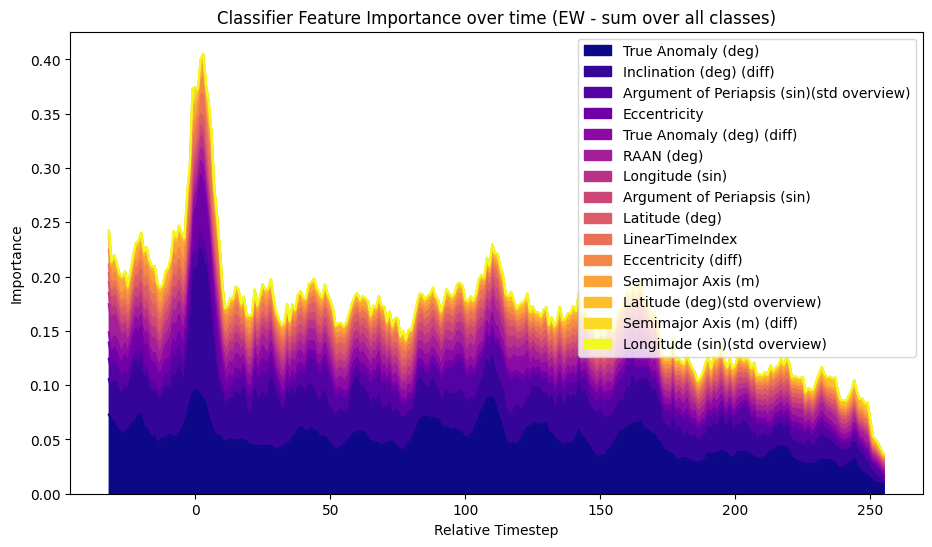

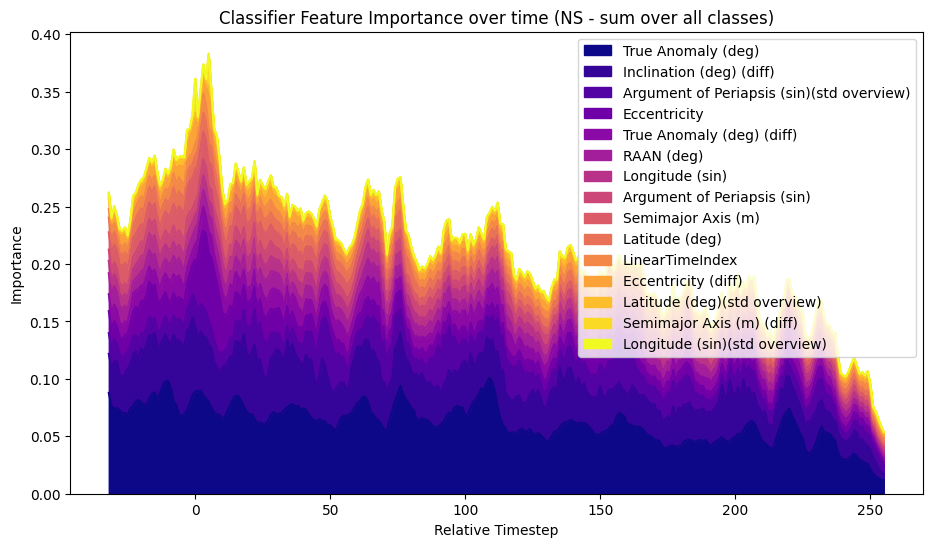

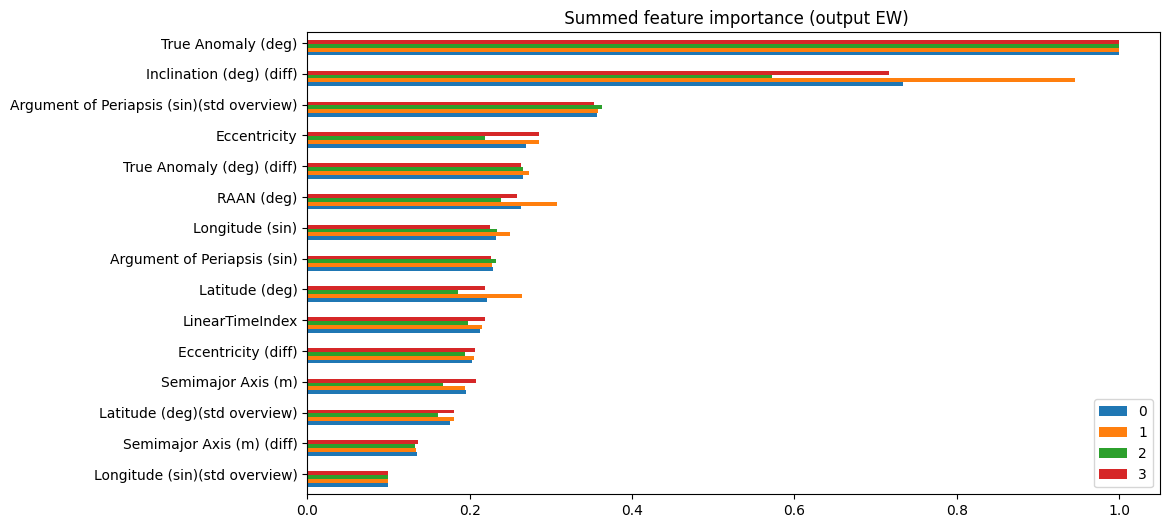

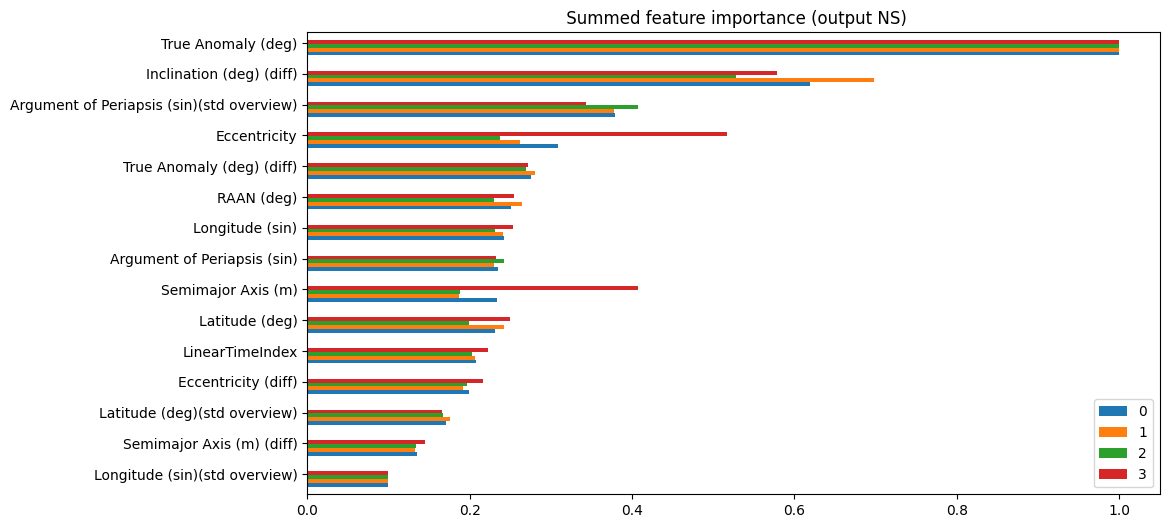

In [73]:
ft_cols = ds_gen._input_features + [ft+'(mean overview)' for ft in ds_gen._overview_features_mean] + [ft+'(std overview)' for ft in ds_gen._overview_features_std]
shap_analysis.plot_ft_importance_over_time(shap_vals,
                                           ft_cols,
                                           title_prefix='Classifier',
                                           time_hist=ds_gen._input_history_steps,
                                           time_fut=ds_gen._input_future_steps,
                                           time_stride=ds_gen._input_stride,
                                           #savefile='img/classifier_feature_importance',
                                           sum_over_classes=True)
shap_analysis.plot_ft_importance_bars(shap_vals, ft_cols)